# Titanic Project Solution using Logistic Regression

This notebook was part of the final submission of a college project undertaken in the 1st year of an Undergraduate Student.
I have approached this very famous problem set using the method of Logistic Regression.

# Logistic Regression
It basically estimates the probability of a certain set of outcomes happening using a given dataset to train the model upon. It does so with the help of the Sigmoid Function or the ReLu function.

# Importing required libraries and csv files

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
        
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Reading data files

In [4]:
train_data = pd.read_csv ('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv ('/kaggle/input/titanic/test.csv')
submission_data = pd.read_csv ('/kaggle/input/titanic/gender_submission.csv')

# Getting an idea about the training dataset

In [5]:
#head function is used to show first 5 records of a dataframe
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Separating columns with numeric entries
This is done because Logistic Regression can only work upon numeric values and not strings/text.
Thus we convert the 'Sex' column to 0s and 1s instead of 'male' and 'female'.

In [7]:
#we will convert 'Sex' column into a numeric one by mapping 'male' to 0 and 'female' to 1
train_data ['Sex'] = train_data ['Sex'].map({'male' : 0, 'female' : 1})
test_data ['Sex'] = test_data ['Sex'].map({'male' : 0, 'female' : 1})

In [8]:
#now we need to separate numeric columns as only those will be used for training the model
num_columns = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex']
train_data_num = train_data [num_columns]

# Looking at correlation of numeric columns with respect to target column 'Survived'

               Age     SibSp     Parch      Fare    Pclass       Sex  Survived
Age       1.000000 -0.308247 -0.189119  0.096067 -0.369226 -0.093254 -0.077221
SibSp    -0.308247  1.000000  0.414838  0.159651  0.083081  0.114631 -0.035322
Parch    -0.189119  0.414838  1.000000  0.216225  0.018443  0.245489  0.081629
Fare      0.096067  0.159651  0.216225  1.000000 -0.549500  0.182333  0.257307
Pclass   -0.369226  0.083081  0.018443 -0.549500  1.000000 -0.131900 -0.338481
Sex      -0.093254  0.114631  0.245489  0.182333 -0.131900  1.000000  0.543351
Survived -0.077221 -0.035322  0.081629  0.257307 -0.338481  0.543351  1.000000


<Axes: >

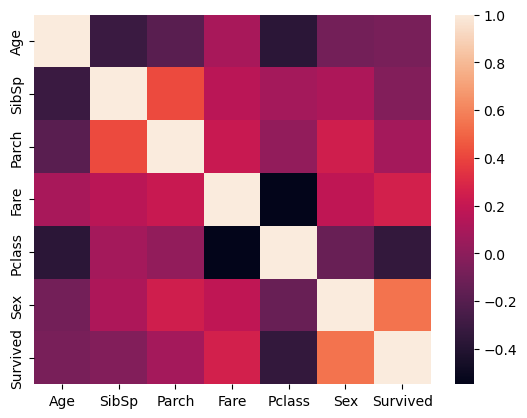

In [9]:
df = train_data [num_columns + ['Survived']]
print (df.corr())
sns.heatmap (df.corr())

In [10]:
#just to get a feel of the data we will look at survived rates per column
pd.pivot_table (train_data, index = 'Survived', values = num_columns)

,Age,Fare,Parch,Pclass,Sex,SibSp
Survived,,,,,,
0,30.626179,22.117887,0.329690,2.531876,0.147541,0.553734
1,28.343690,48.395408,0.464912,1.950292,0.681287,0.473684


# Handling NULL/NAN values
Logistic Regression with throw errors if records with NULL values are used in training/testing. Hence, we are checking for NULL values. We then replace them with the average of the respective columns. (this is possible because we are only taking numeric columns into consideration)

In [11]:
#we will see which dataframes have NAN values
for i in [train_data, test_data, submission_data]:
    print (i.isnull().values.any())

True
True
False


Below one may get a doubt that why we aren't dropping the NULL values instead of replacing them with the column average. This is because of 2 reasons:

1. Dropping of entire records due to some NULL values leads to loss of valuable data, which leads to loss in accuracy of the model.
2. The final gender_submission csv file contains all records, the Survival rates of all passengers have to be predicted. In this case we cannot afford to lose out on any Passenger records.

In [12]:
for i in num_columns:
    train_data[i].fillna (train_data[i].mean(), inplace = True)
    test_data[i].fillna (train_data[i].mean(), inplace = True)

# Declaring X_train and y_train (target column) for training the model
We will use the records and data in the columns in X_train to predict the output (Survival rate) and then train/'fit' our model to be more precise using the result in y_train column.

In [13]:
X_train = train_data [num_columns]
y_train = train_data ['Survived']

In [35]:
X_train

,Age,SibSp,Parch,Fare,Pclass,Sex
0,22.000000,1,0,7.2500,3,0
1,38.000000,1,0,71.2833,1,1
2,26.000000,0,0,7.9250,3,1
3,35.000000,1,0,53.1000,1,1
4,35.000000,0,0,8.0500,3,0
...,...,...,...,...,...,...
886,27.000000,0,0,13.0000,2,0
887,19.000000,0,0,30.0000,1,1
888,29.699118,1,2,23.4500,3,1
889,26.000000,0,0,30.0000,1,0


In [36]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

# Applying Logistic Regression
Importing the required libraries for Logistic Regression and declaring the Logistic Regressor variable

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 2000)
#logistic regressor

Here, 'parameter' basically contains a set of hyper-parameters which we will use for training and fitting our model. Tweaking these hyper-parameters and doing trial-and-error will give us the best set to be used in our model.

In [15]:
parameters = {'penalty' : ['l1', 'l2'], 
              'C' : np.logspace (-4,4,20), 
              'max_iter' : [100,200,300,400,500], 
              'solver' : ['liblinear']}
classifier_regressor = GridSearchCV (lr, param_grid = parameters,
                                     scoring = 'accuracy',
                                     verbose = True, cv = 5)

Sometimes, 'Label Encoding' is required, which converts the categorical data into numerical ones, but it assigns a unique number(starting from 0) to each class of data. Refer to https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/ for more info.
Here though, it is not required as we have already done labelling before.

In [22]:
#from sklearn.preprocessing import LabelEncoder
#label_encoder = LabelEncoder ()
#y_train_encoded = label_encoder.fit_transform (y_train)

# Fitting/Training the model using Logistic Regression
This is the most important step which determines whether our model is able to 'fit' the training data and make predictions accurately for new data

In [23]:
classifier_regressor.fit (X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 200, 300, 400, 500],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=True)

# Prediction of Outcomes using test_data
Using X_test and our model, we will predict the Survival rates of all Passengers and then compared the predicted result with the result already given, i.e., in the gender_submission.csv file

In [24]:
submission_data

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Here, X_test comes from the test_data file but the target column is missing, which we will predict using our model.

In [25]:
X_test = test_data [num_columns]
y_test = submission_data ['Survived']

In [26]:
X_test

,Age,SibSp,Parch,Fare,Pclass,Sex
0,34.500000,0,0,7.8292,3,0
1,47.000000,1,0,7.0000,3,1
2,62.000000,0,0,9.6875,2,0
3,27.000000,0,0,8.6625,3,0
4,22.000000,1,1,12.2875,3,1
...,...,...,...,...,...,...
413,29.699118,0,0,8.0500,3,0
414,39.000000,0,0,108.9000,1,1
415,38.500000,0,0,7.2500,3,0
416,29.699118,0,0,8.0500,3,0


In [27]:
y_test

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int64

# Prediction of Outcomes (here Survival rates) using our Logistic Regression Model 

In [28]:
from sklearn.metrics import classification_report
y_pred = classifier_regressor.predict (X_test)

In [29]:
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Checking Accuracy of Model using Classification Report

As we can see from the report below, that the accuracy of our model is **96%** and hence it is a good and successful model.

In [34]:
print (classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       266
           1       0.94      0.94      0.94       152

    accuracy                           0.96       418
   macro avg       0.95      0.95      0.95       418
weighted avg       0.96      0.96      0.96       418



# Final Step: Making the Submission csv file using a Dataframe we will create
Here, the Dataframe and hence the final csv file contains only 2 columns, i.e., 'PassengerId' and 'Survived'.

In [33]:
output = pd.DataFrame ({'PassengerId' : test_data.PassengerId, 'Survived' : y_pred})
output.to_csv('submission.csv', index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Final Comments and Summary
This marks the end of the data analysis done on the Titanic Dataset.

We analysed the training data and then cleaned (& pre-processed, by taking care of NULL/NAN values) the training and testing data. As we used Logistic Regression, so only the numeric columns were used by the model. After fitting our model on the training data, we used the testing data to predict the target column ('Survived') and compared the results with the given Survival rates in the gender_submissions csv file.